In [1]:
# For reading data filenames 
import glob


# For calculating Time 
import datetime


# For processing data
import math
import pandas as pd
import numpy as np

## For Features Creation
from feature_engineering import *

## For Model Building
import lightgbm as lgb


## For Model Evaluation
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, accuracy_score


## For Sequence Model
from sklearn.utils import class_weight
from keras import Sequential
from keras.layers import Dense, LSTM

## For Plotting Graphs
import matplotlib
import matplotlib.pyplot  as plt

## For ignoring Warning
import warnings
warnings.filterwarnings('ignore')




Using TensorFlow backend.


In [2]:
## Path of data sets
train_path = '../01_Data/Train/*.csv'
test_path = '../01_Data/Validation/*.csv'
labels_path = '../01_Data/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv'
output_path = '../03_Results/test_pred2.csv'

In [3]:
## Load the data and sorted the data at boookingID*second level

def data_load_fun(train_path):
    start = datetime.datetime.now().replace(microsecond=0)
    features = pd.DataFrame()
    filename = []
    for files in glob.glob(train_path):
        filename.append(files)
    for file in filename:
        print (file)
        tmp_df = pd.read_csv(file)
        features = pd.concat([features,tmp_df], axis=0)
    features = features.sort_values(by= ['bookingID',"second"])
    end = datetime.datetime.now().replace(microsecond=0)
    print (len(filename), " Files Loaded Successfuly; Time Taken -->" ,end-start)
    return features
    

In [4]:
def data_pre_processing(df):
    df = df[df.second <10000]
    return df

In [5]:
## Features Creation
def features_creation(features,labels,train_ind=False):
    start = datetime.datetime.now().replace(microsecond=0)
    
    features = generic_features_creation_01(features)
    
    windows_feas1 = window_features_creation1_03(features,window_size=10,over_wd=5,
                                   cols =['Accuracy','Bearing','Speed','gyro','acceleration','acc_cal'])
    windows_feas2 = window_features_creation1_03(features,window_size=10,over_wd=5,
                                   cols =['signal_weak','stop','trip_start','missing_ind','trip_end'], 
                                    metrics = {"sum","max"})
    window_feas_final = pd.merge(windows_feas1, windows_feas2, on= ['bookingID','window'], how = "left")
    end = datetime.datetime.now().replace(microsecond=0)
    print (window_feas_final.shape[1], " Features Created at sliding waindow of 10s with overlap of 5s; Time Taken->", end-start)
    
    fset1 = generic_trip_features_02(features)
    fset2 = window_grp_stop_04(window_feas_final)
    fset3 = window_grp_speed_05(window_feas_final)
    fset4 = window_grp_bearing_06(window_feas_final, cols = ['Bearing_std',"Bearing_max","Bearing_min"], thres=10, var_nm="turn")
    fset5 = trip_ending_fes_07(window_feas_final)
    fset6 = window_grp_accuracy_08(window_feas_final)
    fset7 = generic_stats_features_09(window_feas_final, cols= ["Speed","acc_cal","Accuracy","acceleration","gyro"])
    fset8 = events_calculation_10(window_feas_final)

    fset=fset1.copy()
    fset = fset.merge(fset2, on = ['bookingID'], how = "left")
    fset = fset.merge(fset3, on = ['bookingID'], how = "left")
    fset = fset.merge(fset4, on = ['bookingID'], how = "left")
    fset = fset.merge(fset5, on = ['bookingID'], how = "left")
    fset = fset.merge(fset6, on = ['bookingID'], how = "left")
    fset = fset.merge(fset7, on = ['bookingID'], how = "left")
    fset = fset.merge(fset8, on = ['bookingID'], how = "left")
    
    end1 = datetime.datetime.now().replace(microsecond=0)
    print (fset.shape[1], " Features Created from windows data; Time taken ->", end1- end)
    
    lstm_fset,lstm_y,bids = lstm_features_12(window_feas_final, labels,train_ind=train_ind)
    end2 = datetime.datetime.now().replace(microsecond=0)
    print (lstm_fset.shape, " LSTM Features Created Done; Time taken ->", end2- end1)
    return fset,lstm_fset,lstm_y,bids

In [6]:
def data_full_processing(path,labels,train_ind=False):
    data = data_load_fun(path)
    data = data_pre_processing(data)
    features,lstm_features,lstm_y,lstm_bids = features_creation(data,labels,train_ind=train_ind)
    return features,lstm_features,lstm_y,lstm_bids
    

In [7]:
## read Labels and Incase keep the positive value 
labels = pd.read_csv(labels_path)
labels = labels.groupby(['bookingID']).max().reset_index()
labels.shape

(20000, 2)

In [8]:
train_features,train_lstm_features,train_lstm_y,train_lstm_bids = data_full_processing(train_path,labels,train_ind=True)

../01_Data/Train/part-00001-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
../01_Data/Train/part-00007-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
../01_Data/Train/part-00002-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
../01_Data/Train/part-00003-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
../01_Data/Train/part-00004-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
../01_Data/Train/part-00008-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
../01_Data/Train/part-00009-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
../01_Data/Train/part-00006-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
../01_Data/Train/part-00005-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
../01_Data/Train/part-00000-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
10  Files Loaded Successfuly; Time Taken --> 0:00:57
36  Features Created at sliding waindow of 10s with overlap of 5s; Time Taken-> 0:29:38
47  Features Created from windows data; Time taken -> 0:01:59
(19987, 100, 6)  LSTM Features Created Done; Time taken -

In [9]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_lstm_y),
                                                 train_lstm_y)
model_lstm = Sequential()
model_lstm.add(LSTM(units=8, return_sequences= True, input_shape=(train_lstm_features.shape[1],
                                                                  train_lstm_features.shape[2])))
model_lstm.add(LSTM(units=5))
model_lstm.add(Dense(units=1,activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.fit(train_lstm_features, train_lstm_y, epochs=20, batch_size=256, class_weight=class_weights)

Epoch 1/20
19987/19987 [==============================] - 10s 491us/step - loss: 0.6360 - acc: 0.6961
Epoch 2/20
19987/19987 [==============================] - 9s 429us/step - loss: 0.5631 - acc: 0.7502
Epoch 3/20
19987/19987 [==============================] - 9s 429us/step - loss: 0.5613 - acc: 0.7503
Epoch 4/20
19987/19987 [==============================] - 8s 425us/step - loss: 0.5598 - acc: 0.7503
Epoch 5/20
19987/19987 [==============================] - 9s 428us/step - loss: 0.5531 - acc: 0.7503
Epoch 6/20
19987/19987 [==============================] - 9s 431us/step - loss: 0.5421 - acc: 0.7503
Epoch 7/20
19987/19987 [==============================] - 9s 427us/step - loss: 0.5400 - acc: 0.7503
Epoch 8/20
19987/19987 [==============================] - 9s 429us/step - loss: 0.5376 - acc: 0.7503
Epoch 9/20
19987/19987 [==============================] - 9s 427us/step - loss: 0.5368 - acc: 0.7503
Epoch 10/20
19987/19987 [==============================] - 8s 425us/step - loss: 0.5344 - 

In [10]:
lstm_score = pd.DataFrame()
lstm_score['bookingID'] = train_lstm_bids
lstm_score['lstm_score'] = model_lstm.predict_proba(train_lstm_features)

In [11]:
train_features = pd.merge(train_features, labels, on= ['bookingID'], how="left")
train_features = pd.merge(train_features, lstm_score, on= ['bookingID'], how="left")


In [12]:
drop_cols = ['bookingID','label']
train_target = train_features[['bookingID','label']]
train_features = train_features.drop(columns = drop_cols, axis=1)
train_features.shape, train_target.shape

((20000, 47), (20000, 2))

In [13]:
best_params = {'num_leaves': 8, 'colsample_bytree': 0.7414265939570617, 'max_depth': 6, 
               'learning_rate': 0.019922131503094735, 'subsample': 0.5675422486112608,
 'min_data_in_leaf': 51, 'min_sum_hessian_in_leaf': 10, 'bagging_freq': 9, "scale_pos_weight": (1 - np.mean(train_target.label))/np.mean(train_target.label)}

model = lgb.LGBMClassifier(**best_params, n_estimators = 200, nthread = 4, n_jobs = -1)
model.fit(train_features, train_target.label)

LGBMClassifier(bagging_freq=9, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7414265939570617,
        learning_rate=0.019922131503094735, max_depth=6,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=51,
        min_split_gain=0.0, min_sum_hessian_in_leaf=10, n_estimators=200,
        n_jobs=-1, nthread=4, num_leaves=8, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=2.9992001599680065, silent=True,
        subsample=0.5675422486112608, subsample_for_bin=200000,
        subsample_freq=1)

stats--->

Train ROC -->  0.7606760533352361


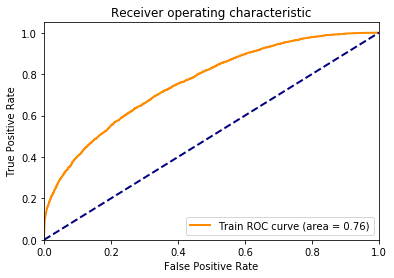

In [14]:
train_pred = model.predict_proba(train_features)[:,1]

print ("stats--->")
print ("")
#y_train_pred = len*[0]


fpr_train, tpr_train, thresholds = roc_curve(train_target.label,train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

print ("Train ROC --> ", roc_auc_train)

plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
#plt.plot(fpr_val, tpr_val, color='red', lw=2, label='Val ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
test_features,test_lstm_features,test_lstm_y,test_lstm_bids = data_full_processing(test_path,labels)

../01_Data/Validation/validation.csv
1  Files Loaded Successfuly; Time Taken --> 0:00:03
36  Features Created at sliding waindow of 10s with overlap of 5s; Time Taken-> 0:00:15
47  Features Created from windows data; Time taken -> 0:00:08
(1436, 100, 6)  LSTM Features Created Done; Time taken -> 0:00:04


In [16]:
test_lstm_score = pd.DataFrame()
test_lstm_score['bookingID'] = test_lstm_bids
test_lstm_score['lstm_score'] = model_lstm.predict_proba(test_lstm_features)

In [17]:
test_features = pd.merge(test_features, test_lstm_score, on= ['bookingID'], how="left")
drop_cols = ['bookingID']
test_target = test_features[['bookingID']]
test_features = test_features.drop(columns = drop_cols, axis=1)
test_features.shape, test_target.shape

((1437, 47), (1437, 1))

In [18]:
test_target['score'] = model.predict_proba(test_features)[:,1]
test_target.shape

(1437, 2)

In [19]:
test_target.to_csv(output_path,index = False)

In [33]:
import shap
shap.initjs()

In [37]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_features)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)


In [38]:
shap.force_plot(explainer.expected_value, shap_values[130,:], train_features.iloc[130,:])

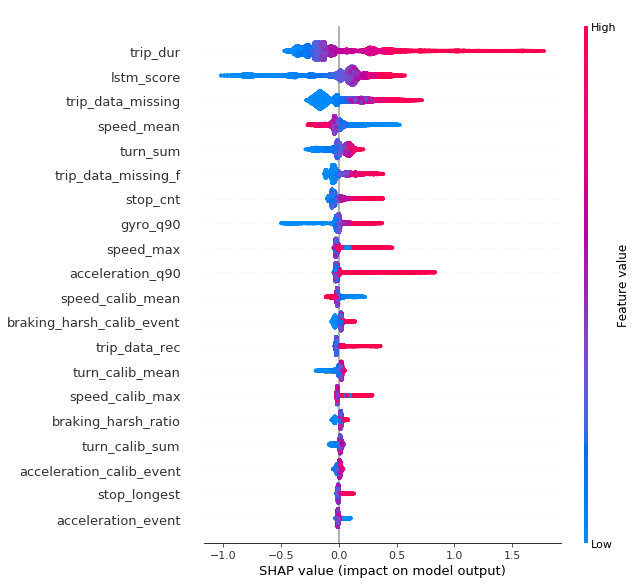

In [35]:
shap.summary_plot(shap_values, train_features)


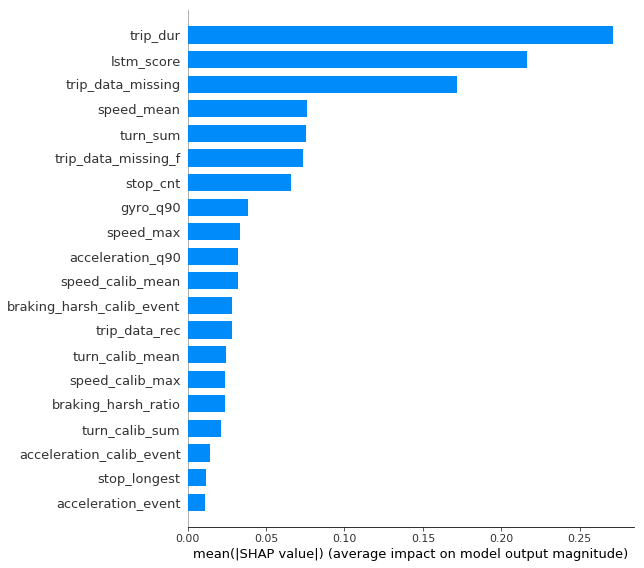

In [27]:
shap.summary_plot(shap_values, train_features, plot_type="bar")


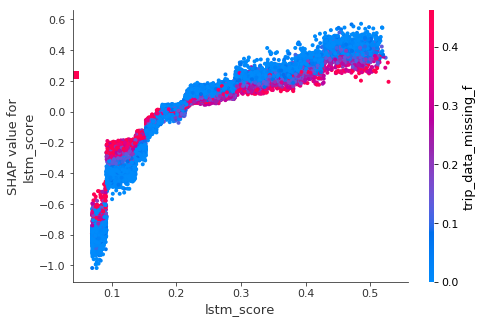

In [29]:
shap.dependence_plot("lstm_score", shap_values, train_features)
